# Л1: Основы обработки изображений и видео CV (Computer Vision). Начало работы с OpenCV

**CV (Computer Vision)**, или *машинное зрение*, — это область искусственного интеллекта, которая занимается разработкой алгоритмов и методов, позволяющих компьютерам "видеть" и интерпретировать изображения и видео. Основная задача компьютерного зрения — автоматическое извлечение полезной информации из визуальных данных, например, распознавание объектов, определение их местоположения или анализ сцен. Это может включать такие приложения, как автоматизация вождения, распознавание лиц и обработка медицинских изображений.

**OpenCV (Open Source Computer Vision Library)** — библиотека алгоритмов компьютерного зрения, обработки изображений и численных алгоритмов общего назначения с открытым кодом

## ☝️ПОРЯДОК ВЫПОЛНЕНИЯ

ЛР выполняется последователньно. По мере продвижения по работе вы будете получать задания для закрепления прочитанной теории

✏️ **ЗАДАНИЕ 1.**
✏️ **ЗАДАНИЕ 2.** и т.д.

Для каждого задания создается отдельный скрипт Python. Всего заданий будет 4. В качестве отчета необходимо предоставить файлы кода для каждого задания. Отчет закреплять на moodle.

## 1/ Подготовка среды выполнения
На данной этапе вам наобходимо подготовить виртуальное окружение и установить все необходимые библиотеки.

1. Создать и активировать (или только активировать, если ранне создавали) виртуальной окружение `python`.

Создайте на диске свою раюочую папку. Откройте терминал и перейдите в свою рабочую директорию
```
cd path/to/your/workspace
```
Далее создаем виртуальное окружение с помощью `python-venv`
```
python -m venv env
```
*активируем виртуальное окружение*
для CMD:
```
env\Scripts\activate
```
для PowerShell
```
env\Scripts\Activate.ps1
```
для bash
```
source env/bin/activate
```
**Примечание.** `env` - это название вашего виртуального окружения, назвать его можете как угодно.

После этого можем выбрать наш локальный интерпрететор pyhton, нажав на кнопку выше "Select kernel".

1. Устанавливаем все необходимые библиотеки

**Примечание.** Библиотеки установятся внутрь вашего виртуального окружения.

Нам понадобятся opencv-python.
```
pip install opencv-python
```

## 2/ Получение видеопотока

В качестве источника изображения (видео) используется вебкамера, подключенная к одноплатному компьютеру Jetson Nano. Он является сервером, создает multicast UDP видеопоток разрешения 640х480, 30fps. Для получения видеопотока необходимо создать UDP сокет и подключится к multicast группе.

In [ ]:
import socket
import cv2
import numpy as np

In [ ]:
# Настройки multicast
MCAST_GRP = '239.1.1.1'
MCAST_PORT = 5007

In [ ]:
# Создаем UDP сокет
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM, socket.IPPROTO_UDP)
sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)

# Присоединяемся к multicast группе
sock.bind(('', MCAST_PORT))
mreq = socket.inet_aton(MCAST_GRP) + socket.inet_aton('0.0.0.0')
sock.setsockopt(socket.IPPROTO_IP, socket.IP_ADD_MEMBERSHIP, mreq)

По сокету мы получаем байтовый массив, который далее преобразуем в jpeg изображение с помощью OpenCV

In [ ]:
# Получаем данные
data, addr = sock.recvfrom(65536)  # Макс размер UDP пакета

In [ ]:
# Декодируем JPEG в изображение
nparr = np.frombuffer(data, np.uint8) # сырые байты переводим в одномерный массив
frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR) # преобразуем в кадр

После получения кадры его следует вывести в окно с помощбю `cv2.imshow()`:

In [ ]:
if frame is not None:
    cv2.imshow('Multicast Stream', frame)

Получение кадра и его отображение следует поместить в цикл. В цикле необходимо вызывать следующую конструкцию для отслеживания выхода из приложения:
```python
if cv2.waitKey(1) & 0xFF == ord('q'):
    break
```

После выхода из цикла предполагается завершение работы приложения, поэтому необходимо освободить ресурсы. В нашем случае нужно закрыть все окна и закрыть сокет:
```python
cv2.destroyAllWindows()
sock.close()
```

Если вы подключаетесь к своей камере, или читаете видео из файла, то следует создавать объекта видеозахвата:
- для файла
```python
# Захватываем видео
cap = cv2.VideoCapture('video.mp4')
```
- для камеры
```python
# Захватываем видеопоток с вебкамеры
cap = cv2.VideoCapture(0) # или /dev/video0
```
Если камера в системе одна, то порядковый номер будет 0, вторая камера будет 1 и т.д.

Все это стандартные фундаментальные конструкции построения приложения обработки изображения в OpenCV, на базе которой можно создавать более сложные схемы обработки. Ниже прсдставлена стандартная шаблок получения и вывода кадров из файла (или камеры):
```python
import cv2

# Захватываем видеопоток с веб-камеры
cap = cv2.VideoCapture(0)
# или из файла
# cap = cv2.VideoCapture('video.mp4')
while True:
    # Читаем кадр с камеры
    ret, frame = cap.read()
    # Отображаем кадр на экране
    cv2.imshow('WebCam', frame)
    # Ожидание 1 миллисекунды на проверку нажатия клавиши 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освобождаем ресурсы после завершения работы
cap.release()
# Закрываем все окна
cv2.destroyAllWindows()

```

*Примечание.* В случае данной ЛР мы получаем видеопоток по UDP, поэтому обхъект закхвата нам создавать не нужно

✏️ **ЗАДАНИЕ 1.** На основании приведенных примеров кода выше создать базовый скрипт для получения видеопотока и вывода его на экран. *Если вы делаете ЛР самостоятельно дома, то используйте собственную вебкамеру или какой-нибудь видеофайл.*

## 3/ Основные операции с изображением
### 3.1/ Изменение размера изображения
Изменение размера изображения относится к процессу изменения физиче-
ских размеров изображения. Этот процесс может включать увеличение или
уменьшение размеров изображения в пикселях без изменения его содержания.

Изменение размера изображения часто применяется для адаптации изображения под определенные требования или ограничения, такие как размеры экрана, требования социальных сетей или оптимизации для веб-страниц.

Для изменение размера кадра используется функция `cv2.resize(original_image, new_size)`

Мы получаем видеопоток, где видеокадры имеют размер (иными словами разрешение) 640х480. Давайте приведем кадры к другому размеру, например:

In [ ]:
new_size = (1280, 720) # получим размер как для HD разрешения

Тогда в метсе, где конвертируем jpeg кадр вызываем функцию изменения размера:

In [ ]:
resized_frame = cv2.resize(frame, new_size)

И далее отображаем оригинальный и новый кадр в отдельных окнах:

In [ ]:
cv2.imshow("Original Video", frame)
cv2.imshow("Resized Video", resized_frame)

Функция `cv2.resize()` принимает как минимум два обязательных параметра:
исходное изображение (в данном примере `original image`) и желаемый размер
выходного изображения (`пew size`). Третьим, необязательным параметром, является метод интерполяции.

**Интерполяция** в контексте изменения размера изображения — это процесс определения значений пикселей в новом изображении на основе значений пикселей в исходном изображении. Когда мы увеличиваем или уменьшаем размер изображения, нам часто нужно создавать новые пиксели или отбрасывать существующие, и именно интерполяция определяет, как это будет происходить.

Существует несколько методов интерполяции, каждый из которых имеет свои особенности и подходит для разных ситуаций. Самые распространённые из них следующие.

**Интерполяция ближайшим соседом (cv2.INTER_NEAREST):** этот самый простой метод, при котором значение пикселя в новом изображении берётся от ближайшего пикселя в исходном изображении. Он быстр, но часто приводит к появлению ступенчатых контуров (артефактов), особенно при увеличении изображения.

**Билинейная интерполяция (cv2.INTER_LINEAR):** этот метод берёт значения четырёх ближайших пикселей в исходном изображении и вычисляет среднее значение, взвешенное по расстоянию до нового пикселя. Результат получается более сглаженным, чем при интерполяции ближайшим соседом, и подходит для большинства применений.

**Бикубическая интерполяция (cv2.INTER_CUBIC):** этот метод использует 16 ближайших пикселей и полиномиальную функцию для вычисления значения нового пикселя. Он даёт более качественный результат, чем билинейная интерполяция, с меньшим количеством артефактов, но требует больше вычислительных ресурсов.

**Интерполяция Ланцоша (cv2.INTER_LANCZOS4):** это более сложный и ресурсоёмкий метод, который даёт очень хорошие результаты при уменьшении и увеличении изображений. Он особенно подходит для случаев, когда требуется высокая точность и минимизация артефактов.

📌 Если метод интерполяции не указан явно, то библиотека OpenCV применяет *билинейную интерполяцию* по умолчанию.

✏️ **ЗАДАНИЕ 2.** Создать новый скрипт на основе базового, дополнив его следующим функционалом: дополнительно к оригинальному видео вывести еще два с различными отношениям сторон. Например, 1:1 и 16:9

### 3.2/ Обрезка изображения

Обрезка изображения - это процесс выделения и сохранения только определенной части изображения, игнорируюя остальные части. 

Обрезка изображений в компьютерном зрении используется для решения
нескольких задач: во-первых, для выделения и фокусировки на конкретных **областях интереса (ROI - Region of Interest)**, и во-вторых, для уменьшения размера
данных и улучшения эффективности обработки за счет удаления ненужных частей.

Определим область для отрезки (левый верхний угол, правый нижний угол). Для справки ниже приведеан система координат изображения (кадра):
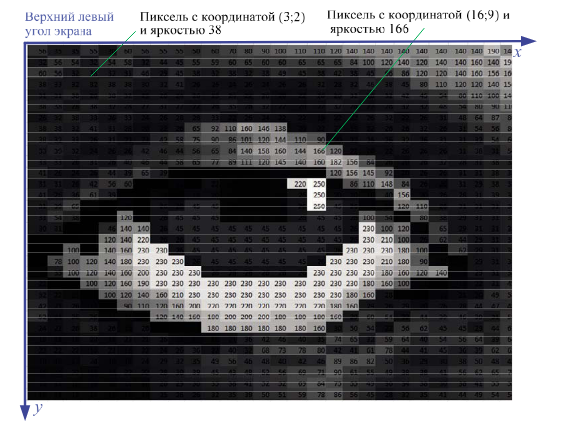

Началом отсчета является верхний левый угол. По горизонтали право растет X, по вертикали вниз расте Y.

In [ ]:
# Определяем квадрат обрезки
box = (500, 100, 600, 250)

Обрезка кадра представляет сообой извлечение сегмента из массива кадра

In [ ]:
# Обрезка кадра
cropped_frame = frame[box[1]:box[3], box[0]:box[2]]

Далее отображаем оба кадра - оригинальный и обрезанный

In [ ]:
# Отображение кадров
cv2.imshow("Video 1", frame) 
cv2.imshow("Video 2", cropped_frame)

✏️ **ЗАДАНИЕ 3.** Разбить оригинальное изображение на 4 равные части и вывести их в отдельных окнах. Дополнительно вырезать небольшую центральную область кадра, увеличить ее размер (см. предыдущее задание) и вывести в отдельном 5 окне

### 3.2/ Вращение изображения

Вращение изображения представляет собой процесс изменения угла положения изображения относительно его начальной ориентации.

Вращение изображения часто применяется для коррекции ориентации, устранения наклона или перевернутого положения, а также для аугментации данных при обучении моделей машинного обучения, чтобы повысить их устойчивость к разным углам обзора.

В библиотеке ОрenCV для реализации процедуры вращения изображения применяют функцию `cv2.getRotationMatrix2D()`. Эта функция создает матрицу преобразования для варщения изображения вокруг определнной точки с заданным углом и коэффициентом масштабирования.

Определим матрицу преобразования вокруг центра. Для этой получим размеры оригинального кадра:

In [ ]:
height, width = frame.shape[:2]

Далее опроеделяем матрицу с вращением вокруг центра на заданный угол `angle` без изменения масштаба (окэффициент масштабирования 1):  

In [ ]:
angle = 45 # Угол вращения (в градусах)
rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

Применяем матрицу преобразования к кадру:

In [ ]:
#  Вращение изображения
rotated_frame = cv2.warpAffine(frame, rotation_matrix, (width, height))

здесь используется функция `cv2.warpAffine()` для вращения изображения с использованием определенной матрицы преобразования.

✏️ **ЗАДАНИЕ 4.** Создать динамическое вращения оригинального изображения в отдельном окне. Для этого в цикле необходимо инкрементировать переменную угла поворота `angel`, чтобы она менялась от 0 до 360 градусов